<a href="https://colab.research.google.com/github/gandys/Masters_Thesis/blob/master/Generar_Una_PCA_y_Guardar_Resultado_(Modular).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# En Colab hay que instalar esta versión de Fastai 
# Puede que salga un error:
# "ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible."
# No es importante, se puede ignorar.
!pip install -q fastai==2.2.5

In [ ]:
#import libraries

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))
import os
import shutil
import glob
from sympy import *
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools as it
from PIL import Image
from IPython.display import clear_output
import random
if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you change the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir
from fastai.tabular.all import *
from skimage import data
from skimage.filters import threshold_multiotsu
import inspect
from sklearn.manifold import TSNE
from sklearn import decomposition
#from sklearn.preprocessing import scaled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import more_itertools
from sklearn.manifold import TSNE
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import imutils
from time import time
init_printing() # Numeros más bonitos

# Generar Potenciales


El primer paso es hacer una función que nos genere un potencial V. Le dices una simetría y te da un DataFrame de Pandas con los valores de x, y, V, bin. Los valores de bin son los valores del potencial agrupados por cuartiles, para evitar repetición de valores y posibles divergencias.

In [ ]:
def potential_df(symmetry = 'None'):
  
  # Generar un solo potencial, pero le tienes que decir la simetría que 
  # quieres que tenga. por defecto pondrá sin simetría.

  [x_min,x_max]=  [-1,1]
  [y_min,y_max]= [-1,1]
  x_num = 200 # Number of values given to x
  y_num = 200 # Number of values given to y
  # inputs es el resultado de emparejar cada x con todas las y
  # Si x = [0,1,2] e y = [a,b], 
  # input = [[0,a],[0,b],[1,a],[1,b],[2,a],[2,b]]
  inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))

  #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
  x_s , y_s = inputs.T #Separamos las parejas

  max_power = 5
  min_power = 1
  count_powers = max_power-min_power+1

  #Una función que te da un array de: [x,x^2,x^3...] entre min_power y max_power
  def powers(var): 
      powers=[]
      for i in range(min_power,max_power+1,1):
          powers.append(var**i)
      return powers

  # Formas de los potenciales
  def V(x,y):
      if symmetry=='continuous_rotation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.sqrt(x**2+y**2)))
      
      if symmetry=='none':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          res = np.array([np.dot(np.array(powers(np.array(x[i]))),np.matmul(c_ij_s,powers(y[i]))) for i in range(len(x_s))])
          return res

      if symmetry=='continuous_translation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.random.normal(0,1)*x+np.random.normal(0,1)*y)) 

      if symmetry=='discrete_translation':
          n_s=6
          ni = np.random.choice([-1,1],n_s) * np.random.normal(5,3, n_s)
          return ni[0]*np.sin(ni[1]*(x)+ni[2]*y) +ni[3]*np.cos(ni[4]*x + ni[5]*y)

      if symmetry=='reflection':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          rn1 = np.random.normal(0,1)
          rn2 = np.random.normal(0,1)
          rn3 = np.random.normal(0,1)
          rn4 = np.random.normal(0,1)
          return np.array([np.dot(powers((rn1*x[i]**2+rn2*y[i]**2)), np.matmul(c_ij_s,powers(rn3*x[i]**2+rn4*y[i]**2))) for i in range(len(x_s))])


  #write a data frame
  data = {
        'x':x_s,        
        'y':y_s,
        'V':V(x_s,y_s)
        }

  df = pd.DataFrame(data,columns=['x','y','V'])


  # Para evitar divergencias y no dar tanta importancia a regiones donde el potencial es muy alto
  # agrupamos los puntos del potencial en bines. Intentamos que haya un bin por 
  # punto del potencial, pero hay puntos en los que el potencial
  # vale lo mismo. Agrupamos esos puntos en bines.

  n_attempted_bins =  len(x_s)

  binning = pd.qcut(df.V, q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
  df['bin']=binning[0]
  #n_actual_bins=len(binning[1])-1

  # Es importante nrmalizar los bines, para que se pueda generalizar a cualquier potencial
  df['bin']=df.bin/np.max(df.bin)

  return df

Generamos un potencial cualquiera, y lo mostramos en una gráfica 3D. En vez de usar los valores de V, usamos directamente los de bin.

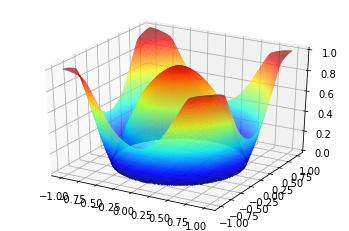

In [ ]:
df = potential_df(symmetry = 'continuous_rotation')
ax = plt.axes(projection='3d')
ax.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')

Vamos a necesitar varios potenciales. Podemos generarlos con la función de arriba.

In [ ]:
# Me genero 10 potenciales con simetria de rotacion continua, por probar

funs = [potential_df(symmetry = 'continuous_rotation') for i in range(10)]
funs_tags = ['continuous_rotation' for i in range(10)] #Etiquetas de los potenciales

In [ ]:
# 10 potenciales sin simetría
funs_none = [potential_df(symmetry = 'none') for i in range(10)]
funs_none_tags = ['none' for i in range(10)]

Comprobamos que los hayamos generado bien mostrando una selección aleatoria de ellos. Hacemos en realidad una proyección de los potenciales para que los muestre más rápido.

In [ ]:
def show_sample(n,funs):
  # Muestra imagenes (proyecciones) aleatorias contenidas en un vector de
  # dataframes de potenciales. Generas los potenciales previamente y los guardas todos en
  # en un array. Esta función te muestra una selección de ellos.
  # Necesita un numero de imagenes que mostrar y un array de dataframes que son
  # los potenciales generados.
  n = int(n)
  num_lado = int(np.ceil(np.sqrt(n)))
  fig = plt.subplots()
  j = 1
  for i in range(num_lado):
    for k in range(num_lado):
      if j <= n:
        axs = plt.subplot2grid((num_lado,num_lado), (i, k))
        img_array= np.array(pd.pivot_table(random.choice(funs),index='y',columns='x',values='bin', fill_value=0))
        axs.imshow(img_array)
        j = j+1
  return


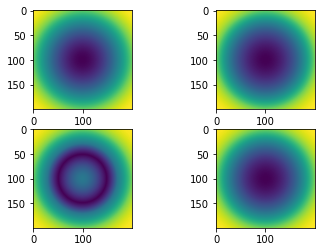

In [ ]:
show_sample(4,funs)

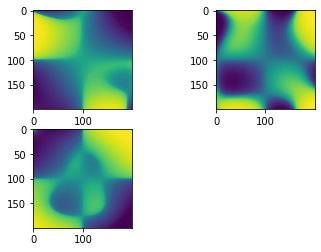

In [ ]:
show_sample(3,funs_none)

Juntamos los potenciales en una sola lista.

In [ ]:
# Sumamos los potenciales que me he generado, tengo un array de todos
potenciales_dos = funs+funs_none
potenciales_dos_tags = funs_tags + funs_none_tags #Etiquetas

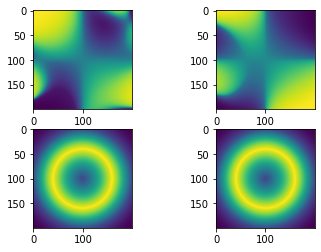

In [ ]:
show_sample(4,potenciales_dos)

# Entrenamiento de una FCNN (Tabular Learner)

Hemos generado una serie de potenciales con distintas simetrías. Vamos a entrenar ahora una red para cada potencial, cuyo objetivo será, dada una pareja de valores {x,y}, predecir el valor del potenciale en ese punto. Para ello, entrenamos la red con el 80% de los puntos y dejamos el 20% para validation.

### Crear un objeto tabular_learner

In [ ]:
df = potenciales_dos[1] #Escojo un potencial
df.drop('V',axis=1)  # Quito los valores del potencial, por si acaso, y me quedo con los bines, 'bin'

,x,y,bin
0,-1.0,-1.000000,0.000000
1,-1.0,-0.989950,0.000109
2,-1.0,-0.979899,0.000435
3,-1.0,-0.969849,0.000979
4,-1.0,-0.959799,0.001522
...,...,...,...
39995,1.0,0.959799,0.001522
39996,1.0,0.969849,0.000870
39997,1.0,0.979899,0.000326
39998,1.0,0.989950,0.000109


In [ ]:
# Tabular Object (TabularPandas) para importar los datos y separarlos en train / validation
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) #20% validation
to = TabularPandas(df,
                  procs=[Categorify,FillMissing, Normalize],
                  cont_names = ['x', 'y'], #Variables continuas
                  y_names = 'bin',
                  splits=splits)

In [ ]:
# Necesitamos un dataloader para crear el learner
train_size = len(splits[0])
valid_size = len(splits[1])
bs = int(train_size/2) #El batch size lo cojo como la mitad del train size. Se puede cambiar.
dls = to.dataloaders(bs=bs)

In [ ]:
#Learner
learn = tabular_learner(dls, layers=[200 for i in range(10)], 
                      # y_range = [min(df.bin),max(df.bin)], #Esto da lugar a una capa extra de neuronas al final tipo sigmoid. Evitaremos ponerlo.
                      #,config=config
                      metrics=[accuracy,error_rate]
                      #,cbs=ShowGraphCallback() #Mostrar la gráfica de aprendizaje
                      #,train_bn=False)
                      )

In [ ]:
[200 for i in range(10)]

### Entrenamiento de la Red

Antes de entrenar la red, veamos de qué potencial se trata.

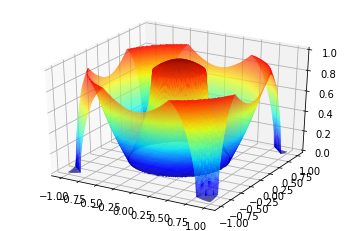

In [ ]:
# Dibujar Potencial
ax = plt.axes(projection='3d')
ax.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')

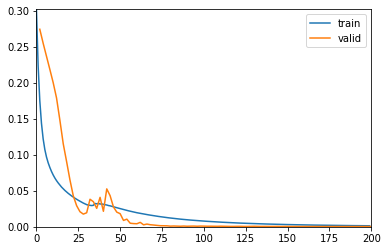

In [ ]:
# Entrenar Red, sin mostrar los resultados de cada epoch explicitamente
with learn.no_logging():
  learn.fit_one_cycle(n_epoch=200, 
                      lr_max = 0.01
                      ,cbs=[ShowGraphCallback()])

Para evaluar lo que ha aprendido la red, una opción es dibujar directamente los datos objetivo (Validation) y las predicciones, y compararlos.

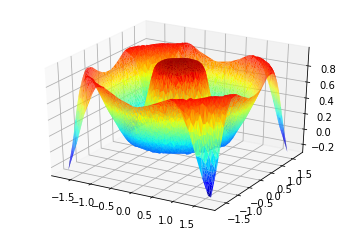

In [ ]:
preds, targs = learn.get_preds()

#Predictions
ax = plt.axes(projection='3d')
ax.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(preds).flatten(), linewidth=0.2, cmap = 'jet')


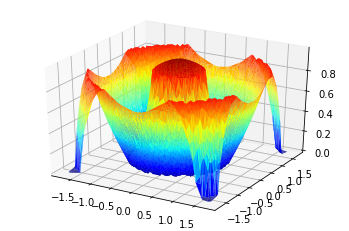

In [ ]:
# Targets
ax = plt.axes(projection='3d')
ax.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(targs).flatten(), linewidth=0.2, cmap = 'jet')

Una evaluación más cuantitativa se puede hacer con la raiz del error cuadratico medio (Root Mean Squared Error, RMSE)

In [ ]:
#RMSE
ff = (preds-targs)**2/len(targs)
ff = sum(ff)
RMSE = np.sqrt(ff)
print('RMSE:',float(RMSE))
print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

RMSE: 0.020006731152534485
Normalized RMSE: 2.0008906498280337 %


In [ ]:
# memory cleanup if needed
#import torch; torch.cuda.empty_cache()
#import gc; gc.collect()

### Función de Resultados

Podemos hacer una función que nos analice directamente los resultados del entrenamiento. Útil cuando hay muchos potenciales.

In [ ]:
def analisis(learn, to, tag, Graph = True):
  preds, targs = learn.get_preds()
  
  #RMSE
  ff = (preds-targs)**2/len(targs)
  ff = sum(ff)
  RMSE = np.sqrt(ff)
  print('RMSE:',float(RMSE))
  print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

  if Graph == True:
    # Targets
    plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(targs).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Targets / Sym =  '+ tag)
    plt.show()

    #Predictions
    plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(preds).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Predictions / Sym =  ' + tag)
    plt.show()

RMSE: 0.020006731152534485
Normalized RMSE: 2.0008906498280337 %


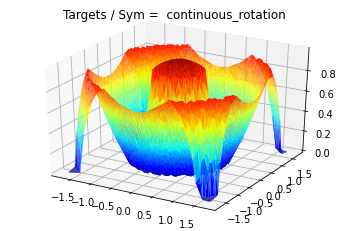

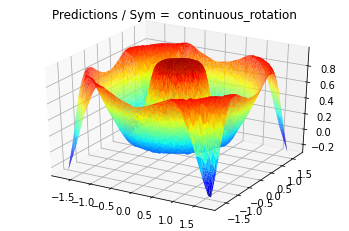

In [ ]:
analisis(learn,to,potenciales_dos_tags[1],Graph = True)

# Obtener una PCA, resultado del entrenamiento de la red.

In [ ]:
dl = learn.dls.test_dl(df,bs=bs) 

# Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
# para guardar, los valores resultantes de la activación de dicha capa. 
with Hooks(learn.model.layers, lambda m,i,o: o) as h:
    preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

targets=preds[2].numpy().flatten()

# Cogemos la información de la penúltima capa (última capa interna)
# OJO: Si añadimos y_range, se añade automaticamente una sigmoid
# al final, por lo que tendríamos que coger la capa -3 en vez de la -2
act = h.stored[-2] 
multi_dim=Tensor.cpu(act).numpy() #Este tensor estaría en la gpu. Para usarlo, lo sacamos de ahí
standardized=StandardScaler().fit_transform(multi_dim)

#Hacemos la PCA 2D de los resultados de la última capa interna
viz = PCA(2).fit_transform(standardized) 

Para más nformación, estudiamos la forma que tienen los resultados de la última y penúltima capa.

In [ ]:
# Última y penúltima capa: útil para descubrir que y_range añadía una capa final

print('-> Ultima Capa:', learn.model.layers[-1], '\n')
print('-> Penultima Capa:', learn.model.layers[-2])

-> Ultima Capa: LinBnDrop(
  (0): Linear(in_features=100, out_features=1, bias=True)
)
-> Penultima Capa: LinBnDrop(
  (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=100, out_features=100, bias=False)
  (2): ReLU(inplace=True)
)


Podemos ver directamente los resultados de la PCA:

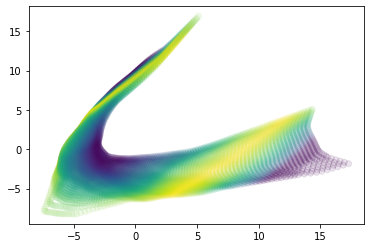

In [ ]:
plt.figure()
plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')


### Guardar la PCA en Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir = os.path.join(top_dir,'drive','MyDrive','PCAs')
if not os.path.isdir(dir):
    print('Creating directory:\n',dir)
    os.mkdir(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
viz.columns = ['x','y'] #Nombres de las columnas
# Insertamos una columna con los colores de los puntos. El valor del potencial
# objetivo (targets) es el color, y hay un color por cada punto 
viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

In [ ]:
# Personalizar mapa de color

n_classes=10

colors = 'rainbow'

if colors == 'rainbow':
    my_cmap = plt.cm.get_cmap('rainbow', n_classes)
    classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap(range(n_classes))))
if colors == 'purple':
    my_cmap = plt.cm.get_cmap('rainbow', n_classes)
    classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

In [ ]:
#Hacer que los colores representen la cantidad de puntos acumuldos en un pixel

n_pixels = 224

binning_3d=np.histogramdd([viz['x'],viz['y'],1+viz['class']],range=(None,None,(-.5,n_classes+.5)), bins=(n_pixels,n_pixels,n_classes+1))
   
#if we want the pixel intensity to reprensent the number of points at that location
array = np.dot(binning_3d[0],classes_in_rgb)
array = array/np.amax(array)

In [ ]:
img_file = str(potenciales_dos_tags[1])+'_PCA.png' # Nombre de la imagen
output_dir = os.path.join(dir,img_file) # Directorio donde guardamos la imagen
plt.imsave(os.path.join(dir,img_file),array) # Guardar
print('\nPCA saved to:\n{}\n'.format(dir+'/'+img_file))



PCA saved to:
/content/drive/MyDrive/PCAscontinuous_rotation_PCA_ts.png

